In [1]:
import astropy
import numpy as np
import pandas as pd
import matplotlib
import scipy

from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter 
from scipy import stats

In [30]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'Black'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = (12, 9)

In [4]:
file = fits.open('/Users/FRANNYPACK/Downloads/grind!/research/Data/MG_Bridge_fg/the actual cube!.fits')
file[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 2892                                                  
NAXIS2  =                 2880                                                  
NAXIS3  =                   56                                                  
BLANK   =                   -1  /                                               
BUNIT   = 'K       '                                                            
DATE-OBS= '2020-05-13T22:16:32.9'  /                                            
TELESCOP= 'ASKAP   '  /                                                         
CRPIX1  =    1.56200000000E+03  /                                               
CDELT1  =   -1.94444444444E-03  /                                               
CRVAL1  =    3.77962750000E+

In [160]:
# gets index of a specific velocity
def v_indx(v_val): # v_val must be in m/s
    v_indx = int((v_val - (2.78503850921 * 10 ** 4)) / (-9.77145310429 * 10 ** 2))
    return v_indx

# TOTAL COLUMN DENSITY (LS + SS)

In [34]:
# plots total column density

def col_dens(arr, vmin, vmax, subtitle, title = 'Column Density'):
    wcs = WCS(file[0].header)
    ax = plt.subplot(projection = wcs, slices = ['x','y',1], zorder = -1)
    plt.grid(b = True, which = 'major', axis = 'both', linewidth = 1, color = 'white')
    plt.xlabel('Right Ascension', fontsize = 20)
    plt.ylabel('Declination', fontsize = 20)
    plt.title(title, y = 1.06, fontsize = 30)
    plt.suptitle(subtitle, x = 0.45, y = 0.93, fontsize = 20)
    plt.imshow(arr, cmap = 'magma', vmin = vmin, vmax = vmax)
    plt.colorbar()

In [6]:
tot_col_dens = 1.82 * (10 ** 18) * np.sum(file[0].data, axis = 0) * 0.977145310429 # in cm^-2, last val = velocity

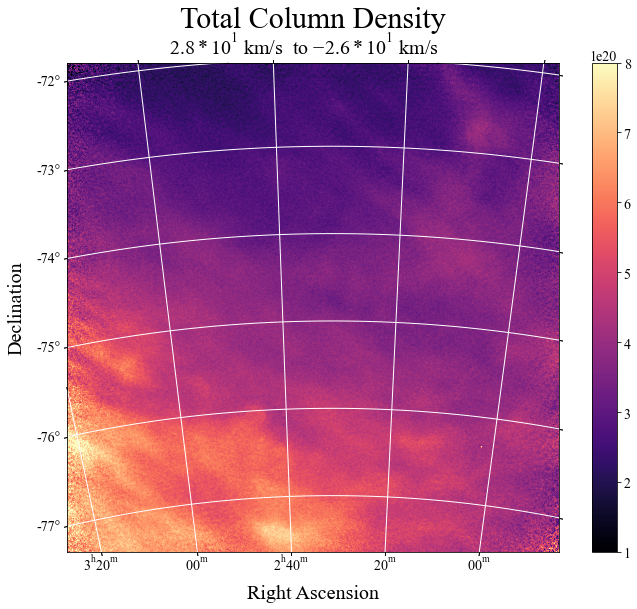

In [35]:
col_dens(tot_col_dens, 1 * 10 ** 20,  0.8 * 10 ** 21, '$\mathregular{2.8 * 10^{1}}$ km/s  to $\mathregular{-2.6 * 10^{1}}$ km/s', title = 'Total Column Density')



In [13]:
col_dens1 = 1.82 * (10 ** 18) * np.nansum(file[0].data[0:16], axis = 0) * 0.977145310429 

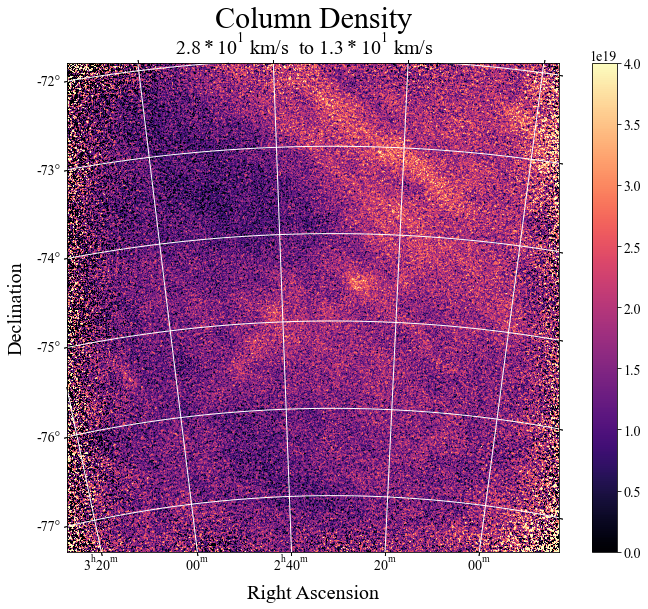

In [36]:
# column density over 2.8 * 10^1 km/s to 1.3 * 10^1 km/s (0th to 22rd index)
# region of velocities where filamentary structures not prominent at all!

col_dens(col_dens1, 0,  0.4 * 10 ** 20, '$\mathregular{2.8 * 10^{1}}$ km/s  to $\mathregular{1.3 * 10^{1}}$ km/s')


In [23]:
col_dens2 = 1.82 * (10 ** 18) * np.nansum(file[0].data[22:34,:,:], axis = 0) * 0.977145310429 

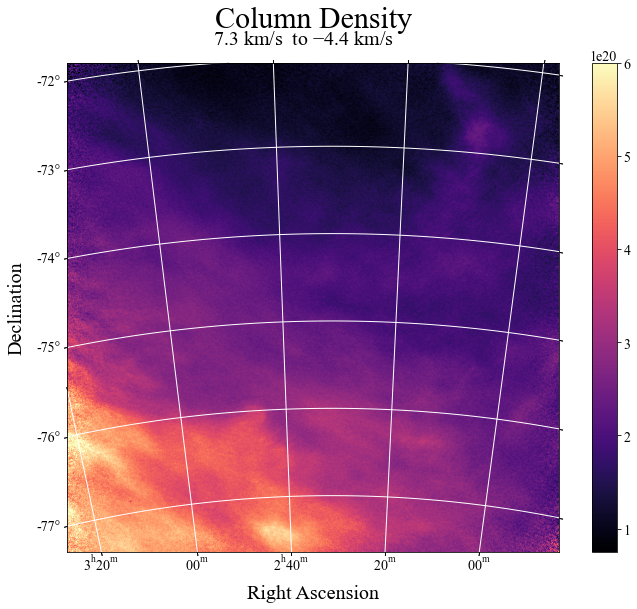

In [37]:
# column density over 7.3 km/s to -4.4 km/s (22nd to 34th index)
# region of velocities where MANY filamentary structures come into play

col_dens(col_dens2, 0.75 * 10 ** 20, 6 * 10 ** 20, '$\mathregular{7.3}$ km/s  to $\mathregular{-4.4}$ km/s')


In [27]:
col_dens3 = 1.82 * (10 ** 18) * np.nansum(file[0].data[44:56,:,:], axis = 0) * 0.977145310429 

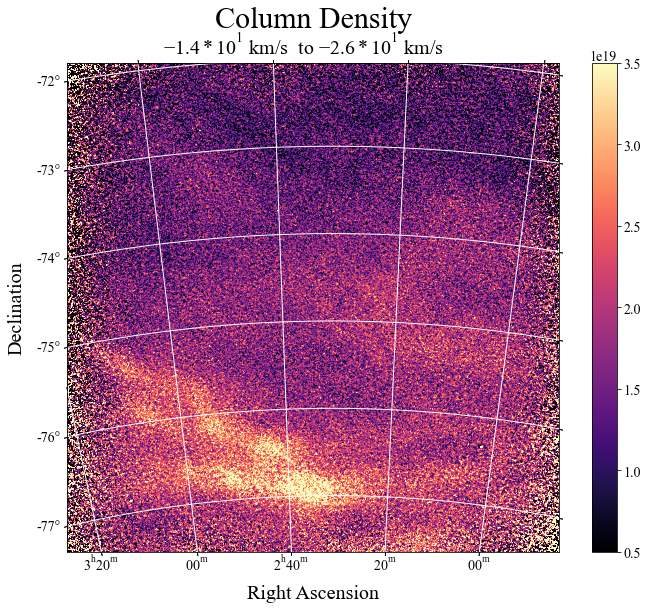

In [38]:
# column density over -1.4 * 10^1 km/s to -2.6 * 10^1 km/s (44th to 56th index)
# region of velocities where filamentary structures not (obviously) prominent at all
 
col_dens(col_dens3, 0.5 * 10 ** 19, 0.35 * 10 ** 20, '$\mathregular{-1.4 * 10^{1}}$ km/s  to $\mathregular{-2.6 * 10^{1}}$ km/s')


In [82]:
# where majority of emission lies
col_dens4 = 1.82 * (10 ** 18) * np.nansum(file[0].data[v_indx(1.4 * 10 ** 4):v_indx(-1.6 * 10 ** 4),:,:], axis = 0) * 0.977145310429 


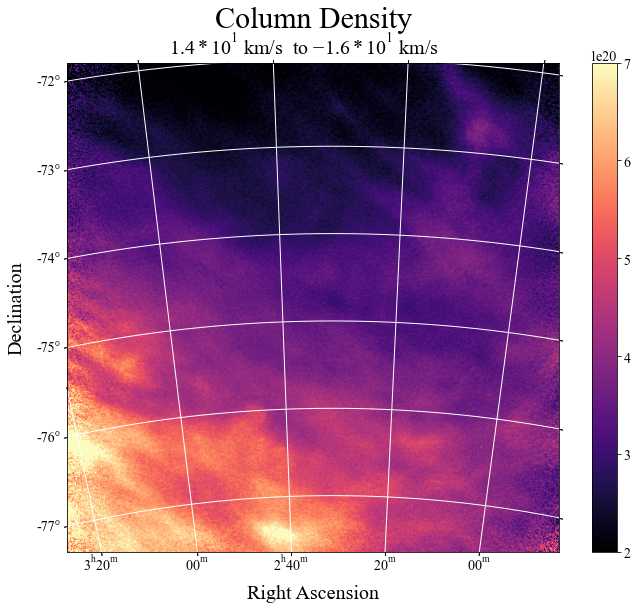

In [87]:
col_dens(col_dens4, 0.2 * 10 ** 21, 0.7 * 10 ** 21, '$\mathregular{1.4 * 10^{1}}$ km/s  to $\mathregular{-1.6 * 10^{1}}$ km/s')


# SMALL-SCALE COLUMN DENSITY MAPS

In [42]:
# does the actual work of the USM

def process_usm(cc_sum, FWHM = 30.):
    
    pix_len = file[0].header['CDELT2'] * 60 # ['CDELT2'] = pixel length in deg, multiply by 60 to convert to arcmin
    FWHM30_pix = FWHM / pix_len # want FWHM to be 30 arcmin, so convert to pixels
    sigma = FWHM30_pix / (2 * np.sqrt(2 * np.log(2))) # converts from FWHM to sigma, since Gaussian filter specified by sigma
    sum_smooth = gaussian_filter(cc_sum, sigma = sigma) # does smoothing using Gaussian filter
    
    sum_USM = cc_sum - sum_smooth
    
    return sum_USM


In [47]:
# for multiple channel maps
# computes unsharp mask over 3 km/s at a time, then adds them up (so as to not wash out the small-scale structure)

def usm_cd(v_indx_min, v_indx_max, FWHM = 30., maskb = False):
    cur = v_indx_min
    num_iterations = int((v_indx_max - v_indx_min) / 3) # 3 km/s = 3 maps at a time
    tot_cd = np.zeros((2880, 2892))
    
    for i in range(num_iterations + 1):
        if (i == num_iterations): # remainder of 3 that we have to integrate over
            if ((v_indx_max - v_indx_min) % 3 == 0): # nothing left to integrate over - we done!
                return tot_cd
            else:
                cd_arr = 1.82 * (10 ** 18) * np.nansum(file[0].data[cur:v_indx_max], axis = 0) * 0.977145310429
        else: 
            cd_arr = 1.82 * (10 ** 18) * np.nansum(file[0].data[cur:cur + 3], axis = 0) * 0.977145310429
        
        if maskb:
            cd_arr = mask_border(cd_arr)
            
        tot_cd += process_usm(cd_arr, FWHM = FWHM)
        cur += 3

    tot_cd[np.where(tot_cd < 0.)] = 0. # at end so negative noise cancels out with positive noise
    return tot_cd

In [44]:
def show_usm(cd, vmin = 0, vmax = 0):
    plt.figure(figsize = (15, 9))
    plt.imshow(np.flip(np.abs(cd), axis = 0), cmap = 'magma', vmin = vmin, vmax = vmax)
    plt.colorbar()

In [48]:
tot_col_dens_SS = usm_cd(0, 55)

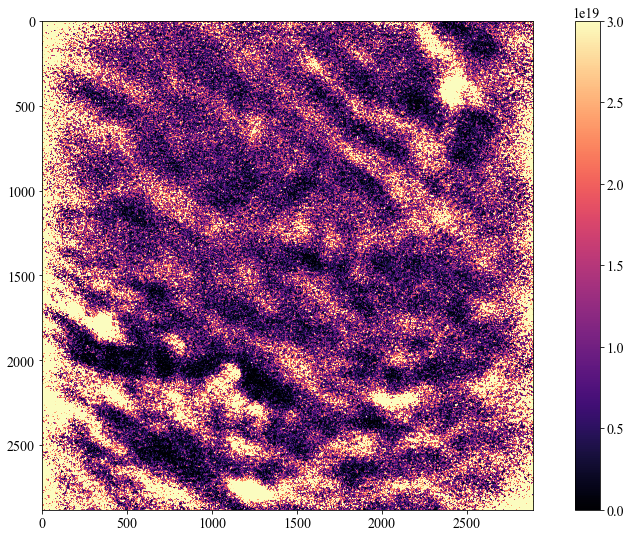

In [52]:
show_usm(tot_col_dens_SS, vmax = 0.3 * 10 ** 20)

In [63]:
col_dens1_SS = usm_cd(0, 16) # not much filamentary structure

In [72]:
col_dens2_SS = usm_cd(22, 34)

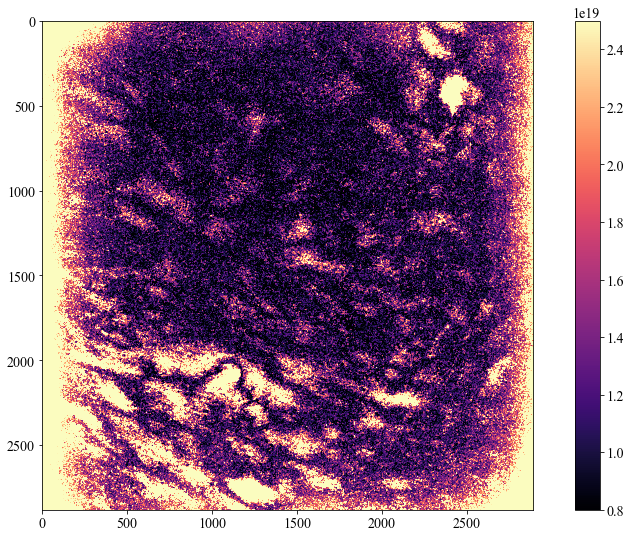

In [77]:
show_usm(col_dens2_SS, vmin = 0.8 * 10 ** 19, vmax = 2.5 * 10 ** 19)

In [78]:
col_dens3_SS = usm_cd(44, 56) # no filamentary structure

In [57]:
col_dens4_SS = usm_cd(v_indx(1.4 * 10 ** 4), v_indx(-1.6 * 10 ** 4))

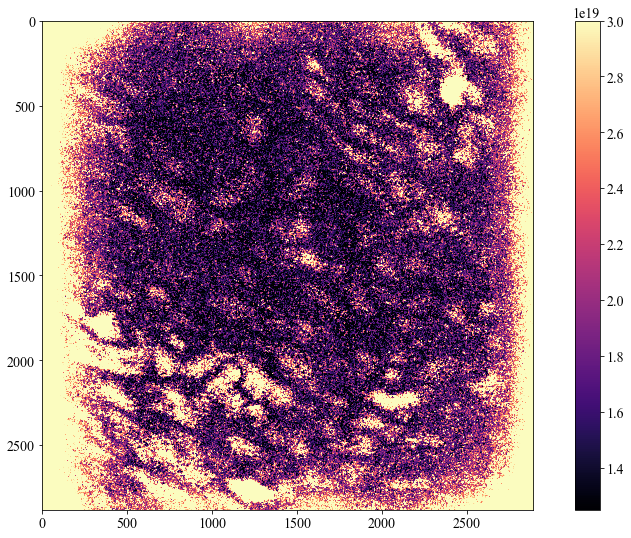

In [62]:
show_usm(col_dens4_SS, vmin = 1.25 * 10 ** 19, vmax = 0.3 * 10 ** 20)

# LARGE-SCALE COLUMN DENSITY MAPS

In [88]:
tot_col_dens_LS = tot_col_dens - tot_col_dens_SS

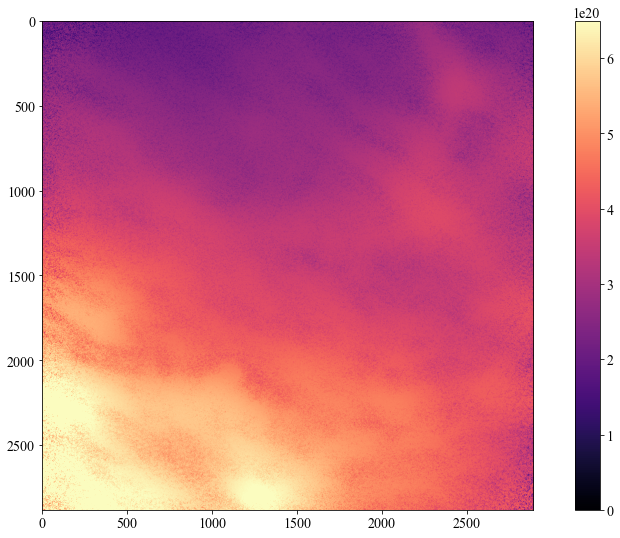

In [91]:
show_usm(tot_col_dens_LS, vmax = 6.5 * 10 ** 20)

In [92]:
col_dens1_LS = col_dens1 - col_dens1_SS

In [96]:
col_dens2_LS = col_dens2 - col_dens2_SS

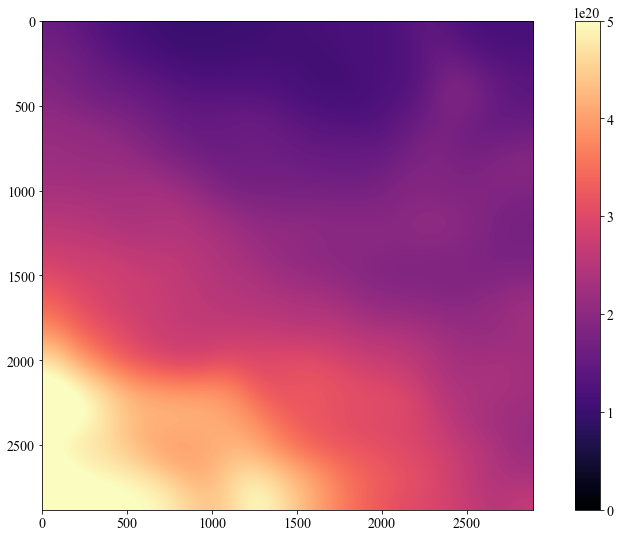

In [98]:
show_usm(col_dens2_LS, vmax = 5 * 10 ** 20)

In [99]:
col_dens3_LS = col_dens3 - col_dens3_SS

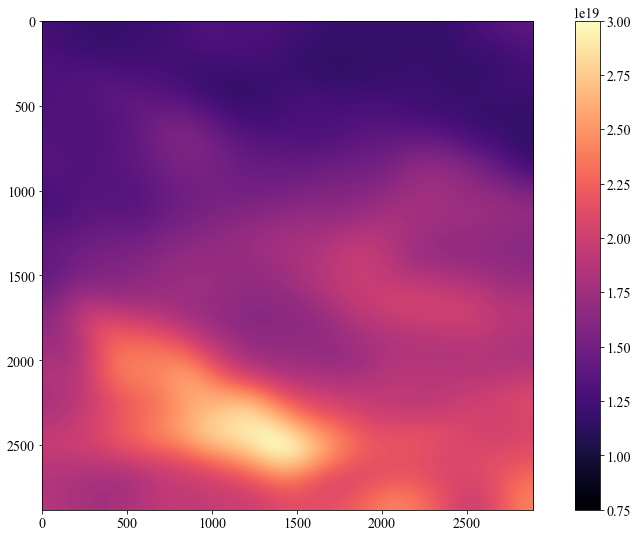

In [105]:
show_usm(col_dens3_LS, vmin = 0.75 * 10 ** 19, vmax = 0.3 * 10 ** 20)

In [106]:
col_dens4_LS = col_dens4 - col_dens4_SS

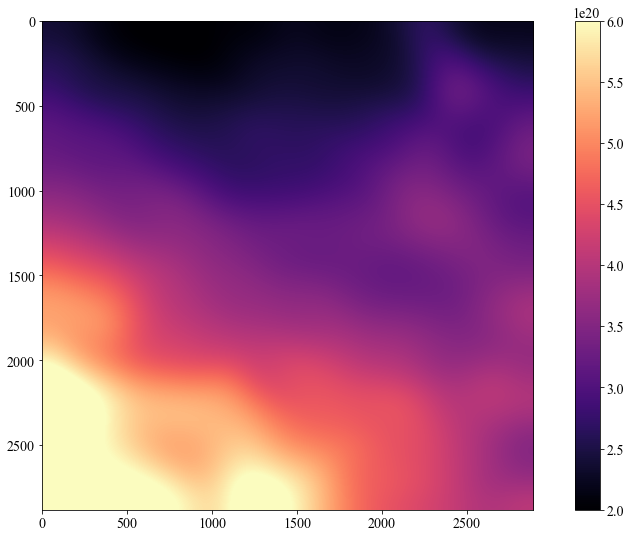

In [116]:
show_usm(col_dens4_LS, vmin = 0.2 * 10 ** 21, vmax = 0.6 * 10 ** 21)

# CALCULATING FRACTION OF SMALL-SCALE/LARGE-SCALE IN TOTAL COLUMN DENSITY

Using entire column density arrays

In [128]:
np.nansum(tot_col_dens_SS) / np.nansum(tot_col_dens)

0.03809910123745701

In [130]:
np.nansum(tot_col_dens_LS) / np.nansum(tot_col_dens)

0.9618999139975806

In [131]:
np.nansum(col_dens1_SS) / np.nansum(col_dens1)

0.42230501298326784

In [132]:
np.nansum(col_dens1_LS) / np.nansum(col_dens1)

0.5776960406370952

In [136]:
np.nansum(col_dens2_SS[np.where(col_dens2_SS > 0)]) / np.nansum(col_dens2[np.where(col_dens2_SS > 0)])

0.060936389837615214

In [137]:
np.nansum(col_dens2_LS[np.where(col_dens2_SS > 0)]) / np.nansum(col_dens2[np.where(col_dens2_SS > 0)])

0.9390634042698809

In [141]:
np.nansum(col_dens3_SS[np.where(col_dens3_SS > 0)]) / np.nansum(col_dens3[np.where(col_dens3_SS > 0)])

0.40498632391828504

In [142]:
np.nansum(col_dens3_LS[np.where(col_dens3_SS > 0)]) / np.nansum(col_dens3[np.where(col_dens3_SS > 0)])

0.5950131498721791

In [144]:
np.nansum(col_dens4_SS[np.where(col_dens4_SS > 0)]) / np.nansum(col_dens4[np.where(col_dens4_SS > 0)])

0.05900503459265319

In [145]:
np.nansum(col_dens4_LS[np.where(col_dens4_SS > 0)]) / np.nansum(col_dens4[np.where(col_dens4_SS > 0)])

0.9409951174216601

# ALL COLUMN DENSITY PLOTS TOGETHER

In [152]:
def all_cd(tot_arr, SS_arr, LS_arr, v_begin, v_end, tot_v_min, tot_v_max, LS_v_max, SS_v_min, SS_v_max):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 8), constrained_layout = True)
    fig.suptitle(str(v_begin) + ' km/s to ' + str(v_end) + ' km/s', y = 0.9, fontsize = 40)
    wcs = WCS(file[0].header)

    ax1.plot(projection = wcs, slices = ['x','y',1], zorder = -1)
    tot = ax1.imshow(np.flip(tot_arr, axis = 0), cmap = 'magma', vmin = tot_v_min, vmax = tot_v_max)
    ax1.set_title('Total Column Density', fontsize = 30)
    cbar1 = fig.colorbar(tot, ax = ax1, orientation = 'horizontal', pad = 0.1)
    
    ax2.plot(projection = wcs, slices = ['x','y',1], zorder = -1)
    LS = ax2.imshow(np.flip(LS_arr, axis = 0), cmap = 'magma', vmin = 0, vmax = LS_v_max)
    ax2.set_title('Large-Scale Column Density', fontsize = 30)
    fig.colorbar(LS, ax = ax2, orientation = 'horizontal', pad = 0.1)
    
    ax3.plot(projection = wcs, slices = ['x','y',1], zorder = -1)
    SS = ax3.imshow(np.flip(SS_arr, axis = 0), cmap = 'magma', vmin = SS_v_min, vmax = SS_v_max)
    ax3.set_title('Small-Scale Column Density', fontsize = 30)
    cbar = fig.colorbar(SS, ax = ax3, orientation = 'horizontal', pad = 0.1)

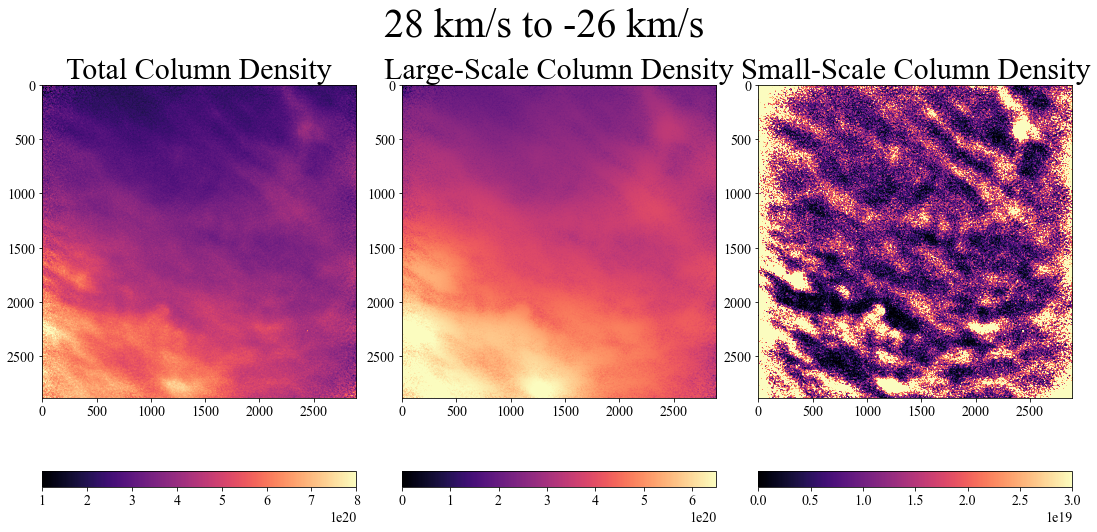

In [153]:
all_cd(tot_col_dens, tot_col_dens_SS, tot_col_dens_LS, 28, -26, 1 * 10 ** 20,  0.8 * 10 ** 21, 6.5 * 10 ** 20, 0, 0.3 * 10 ** 20)



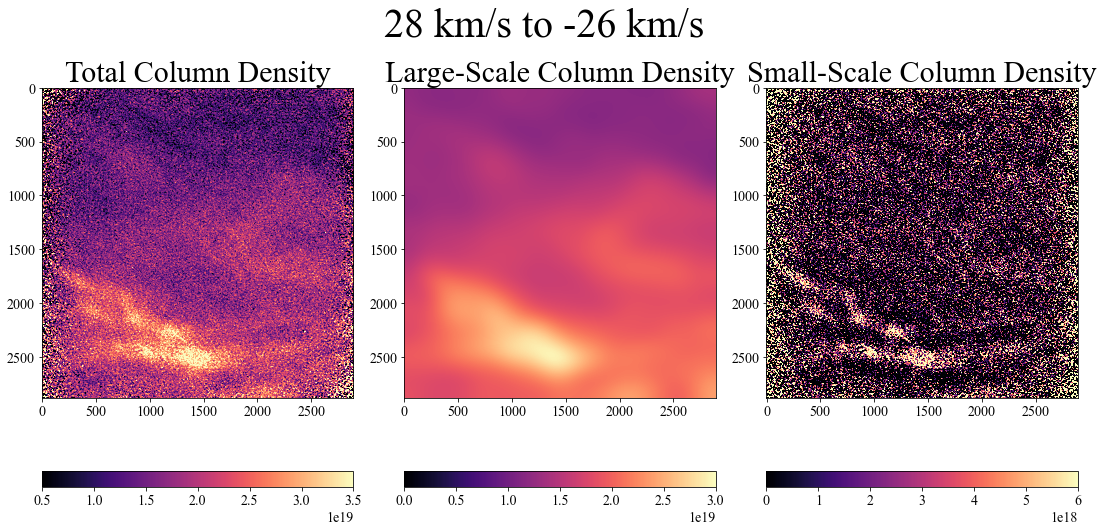

In [159]:
all_cd(col_dens3, col_dens3_SS, col_dens3_LS, 28, -26, 0.5 * 10 ** 19, 0.35 * 10 ** 20, 0.3 * 10 ** 20, 0, 0.6 * 10 ** 19)

